In [2]:
# prompt: READ EXCEL FILE ON COLAB

import pandas as pd

# Download the Excel file from Google Drive
!gdown --id [FILE_ID]

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel('Online Retail.xlsx')

# Display the DataFrame
df.head()


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=[FILE_ID]

but Gdown can't. Please check connections and permissions.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Data Preparation
# 1. Handling Missing Values
df_clean = df.dropna(subset=['CustomerID'])
df_clean['Description'] = df_clean['Description'].fillna('No description')

# 2. Feature Engineering
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


<ipython-input-5-1694c3e9df58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Description'] = df_clean['Description'].fillna('No description')
<ipython-input-5-1694c3e9df58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


In [6]:
# 2. Removing Duplicates
df_clean = df_clean.drop_duplicates()

In [7]:
# 3. Data Cleaning
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

In [8]:
# Calculate RFM values
current_date = df_clean['InvoiceDate'].max() + pd.DateOffset(1)
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum',
    'Quantity': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'TotalQuantity']

In [9]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,TotalQuantity
0,12346.0,326,1,77183.60,74215
1,12347.0,2,182,4310.00,2458
2,12348.0,75,31,1797.24,2341
3,12349.0,19,73,1757.55,631
4,12350.0,310,17,334.40,197


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the RFM values
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary', 'TotalQuantity']])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_normalized)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

rfm.head()


,CustomerID,Recency,Frequency,Monetary,TotalQuantity,PCA1,PCA2
0,12346.0,326,1,77183.60,74215,13.487039,7.350248
1,12347.0,2,182,4310.00,2458,0.666237,-0.812274
2,12348.0,75,31,1797.24,2341,0.039583,-0.058050
3,12349.0,19,73,1757.55,631,0.017936,-0.692234
4,12350.0,310,17,334.40,197,-0.802076,1.990382


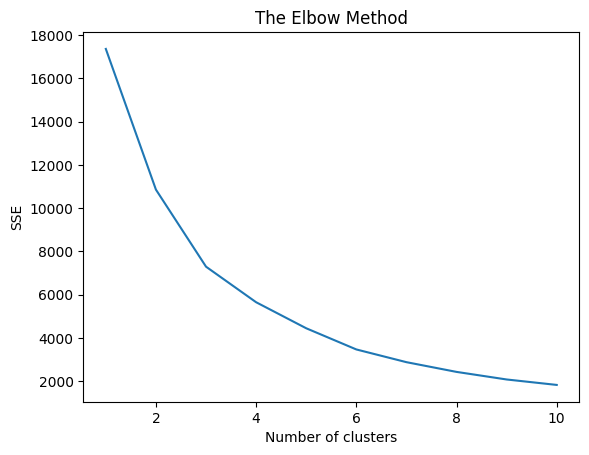

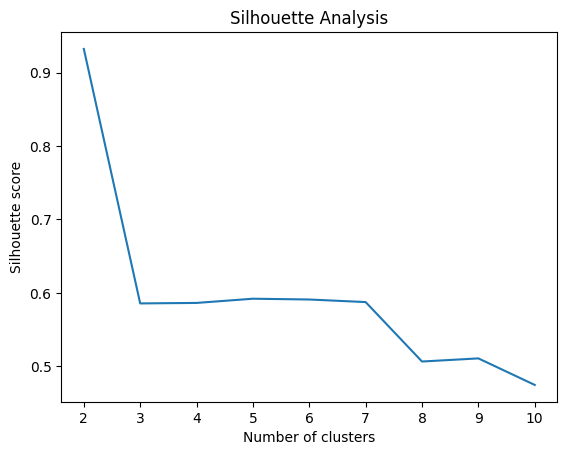

In [11]:
# prompt: Determining Optimal Number of Clusters:
# Employ methods like the elbow method or silhouette analysis to determine the optimal number of clusters for K-means clustering. Experimentation with different values of K is necessary to evaluate the clustering outcome and select the best option.

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(rfm_normalized)
  sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Silhouette analysis
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(rfm_normalized)
  silhouette_scores.append(silhouette_score(rfm_normalized, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [12]:
# K-means Clustering
optimal_clusters = 4  # Choose the optimal number based on the elbow and silhouette analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

rfm.head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,Frequency,Monetary,TotalQuantity,PCA1,PCA2,Cluster
0,12346.0,326,1,77183.60,74215,13.487039,7.350248,1
1,12347.0,2,182,4310.00,2458,0.666237,-0.812274,0
2,12348.0,75,31,1797.24,2341,0.039583,-0.058050,0
3,12349.0,19,73,1757.55,631,0.017936,-0.692234,0
4,12350.0,310,17,334.40,197,-0.802076,1.990382,2


In [13]:
# Cluster Profiling
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'TotalQuantity': ['mean', 'std'],
    'CustomerID': 'count'
}).reset_index()

print(cluster_profile)


  Cluster     Recency               Frequency                    Monetary  \
                 mean        std         mean          std           mean   
0       0   41.349799  35.485970   101.062056   141.134051    1944.456966   
1       1   31.000000  85.576776   915.857143   797.798303  121183.096429   
2       2  247.038853  66.894433    27.438483    30.899151     564.385237   
3       3    2.000000   1.414214  5717.250000  1403.584785   70612.247500   

                TotalQuantity               CustomerID  
            std          mean           std      count  
0   3662.011151   1152.041680   2247.430819       3239  
1  76005.505864  69078.928571  39710.641245         14  
2   1927.218121    285.588344    699.505420       1081  
3  50627.275433  36178.250000  29615.347017          4  


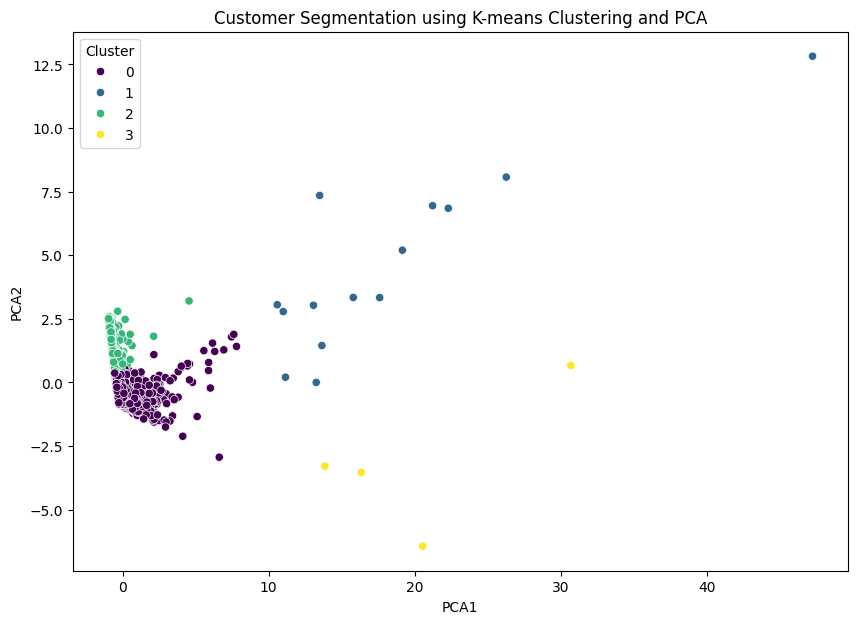

In [15]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segmentation using K-means Clustering and PCA')
plt.show()


In [16]:
# Evaluation
silhouette_avg = silhouette_score(rfm_normalized, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.5863485097458939


**Personalization and Recommendations
Based on the clusters identified, you can tailor your marketing strategies and product recommendations. Here are some examples:**

Cluster 0: High-frequency purchasers - Target with loyalty programs and frequent purchase incentives.
Cluster 1: Low-spending and infrequent purchasers - Offer discounts or engage with reactivation campaigns.
Cluster 2: Moderate spenders and purchasers - Provide upsell and cross-sell opportunities.
Cluster 3: High spenders with less frequent purchases - Focus on premium products and exclusive offers.



 **Interpretation and Insights**

In [17]:
# Save the clustered data for future use
rfm.to_csv('customer_segmentation.csv', index=False)
